In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Install RAPIDS (cuDF + cuGraph) for CUDA 12 (fits T4 GPU)
!pip install cudf-cu12 cugraph-cu12 --extra-index-url=https://pypi.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 145.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 176.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 44.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of cugraph-cu12 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 199.9 MB/s eta 0:00:00


In [4]:
# GPU-accelerated dataframes and graphs
import cudf
import cugraph

from pathlib import Path

# Path to Community Notes dataset (X)
DATA_DIR = Path("/content/drive/MyDrive/communities")

# Files to process (adjust as needed)
parts = [0, 1, 6, 7, 9]
files = [DATA_DIR / f"ratings-{i:05d}.tsv" for i in parts]

print("✅ RAPIDS libraries loaded: using cuDF + cuGraph on GPU")


✅ RAPIDS libraries loaded: using cuDF + cuGraph on GPU


In [6]:
# Cell 1 — Build edges only when two raters agree on label for the same note (Helpful/Not Helpful)

import pandas as pd
import numpy as np
import cudf
import os, gc

def _detect_label_column(header_cols):
    """
    Given a list of columns from a ratings TSV, decide which column to use as the
    'label' and return (label_col_name, mapping_function).
    The mapping function must transform the column to {0,1} where:
      1 = Helpful, 0 = Not Helpful, and return np.nan for anything else (to drop).
    """
    cols = {c.lower(): c for c in header_cols}

    # Case A: boolean/integer helpful flags
    for cand in ["helpful", "ishelpful", "is_helpful", "helpful_flag"]:
        if cand in cols:
            col = cols[cand]
            def map_fun(s):
                # accept bool, {0,1}, {"0","1"}, {"true","false"}
                if s.dtype == "bool":
                    return s.astype("int8")
                # try generic mapping
                return (
                    s.astype(str).str.strip().str.lower()
                     .map({"1":1,"true":1,"t":1,"yes":1,"y":1,"0":0,"false":0,"f":0,"no":0,"n":0})
                     .astype("float32")  # keep nan for unknowns
                )
            return col, map_fun

    # Case B: textual rating field
    for cand in ["rating", "label", "classification", "vote", "helpfulness"]:
        if cand in cols:
            col = cols[cand]
            def map_fun(s):
                t = s.astype(str).str.strip().str.lower()
                # map a variety of common values
                return t.map({
                    "helpful":1,
                    "helpful_agreement":1,
                    "currently_true":1,
                    "not helpful":0,
                    "not_helpful":0,
                    "nothelpful":0,
                    "currently_false":0,
                    "incorrect":0,
                })
            return col, map_fun

    # Case C: helpfulness level (drop anything not strictly helpful/not helpful)
    for cand in ["helpfulnesslevel", "helpfulness_level"]:
        if cand in cols:
            col = cols[cand]
            def map_fun(s):
                t = s.astype(str).str.strip().str.lower()
                # Keep only strict helpful/not helpful; drop neutral/other
                return t.map({"helpful":1, "not helpful":0, "not_helpful":0, "nothelpful":0})
            return col, map_fun

    raise ValueError(
        "Could not find a recognizable rating label column in the ratings file. "
        "Tried helpful/isHelpful/rating/classification/helpfulnessLevel..."
    )

def _yield_labeled_chunks(path, chunksize):
    """
    Stream a ratings file and yield cudf chunks with columns: user, note, label (0/1).
    Drops rows with unknown/neutral labels.
    """
    # Peek header to decide which columns to load
    header = pd.read_csv(path, sep="\t", nrows=0)
    user_col = None
    note_col = None
    for cand in ["raterParticipantId", "participantId", "rater_id", "userId", "user_id"]:
        if cand in header.columns:
            user_col = cand
            break
    for cand in ["noteId", "note_id"]:
        if cand in header.columns:
            note_col = cand
            break
    if user_col is None or note_col is None:
        raise ValueError(f"Missing user/note columns in {path}. Saw columns: {header.columns.tolist()}")

    label_col, map_fun = _detect_label_column(header.columns)

    usecols = [user_col, note_col, label_col]
    for chunk in pd.read_csv(path, sep="\t", chunksize=chunksize, usecols=usecols):
        # normalize to expected names
        chunk = chunk.rename(columns={user_col: "user", note_col: "note", label_col: "label_raw"})
        # map label to {0,1} and drop others
        mapped = map_fun(chunk["label_raw"])
        chunk["label"] = mapped
        chunk = chunk.drop(columns=["label_raw"])
        chunk = chunk.dropna(subset=["label"])  # keep only 0/1
        # enforce minimal dtypes
        chunk["label"] = chunk["label"].astype(np.int8, copy=False)
        # hand off as cuDF for GPU merge/groupby
        yield cudf.from_pandas(chunk[["user","note","label"]])

def process_and_save_edges_same_label(files, chunksize=500_000, out_dir="edges"):
    """
    Stream ratings files, keep only pairs of raters who gave the SAME label on the SAME note.
    For each chunk:
      - self-join on ['note','label'] (not just 'note')
      - undirected pairs user_src < user_dst
      - count edges (weight)
      - save parquet edges_{i}.parquet with columns: user_src, user_dst, weight
    """
    os.makedirs(out_dir, exist_ok=True)
    chunk_id = 0

    for f in files:
        print("Reading:", f)
        for gdf in _yield_labeled_chunks(f, chunksize=chunksize):
            # self-join on (note, label) so we only connect same-label co-raters
            merged = gdf.merge(gdf, on=["note","label"], suffixes=("_src", "_dst"))
            merged = merged[merged["user_src"] < merged["user_dst"]]

            edges = merged.groupby(["user_src","user_dst"]).size().reset_index(name="weight")
            out_path = os.path.join(out_dir, f"edges_{chunk_id}.parquet")
            edges.to_parquet(out_path)
            print(f"  ✅ chunk {chunk_id} → edges: {len(edges)} → {os.path.basename(out_path)}")

            del gdf, merged, edges
            gc.collect()
            chunk_id += 1

# --- Example run (same as before, just call the new function) ---
parts = [0, 1, 6, 7, 9]
files = [f"/content/drive/MyDrive/communities/ratings-{i:05d}.tsv" for i in parts]
process_and_save_edges_same_label(files, chunksize=500_000, out_dir="edges")


Reading: /content/drive/MyDrive/communities/ratings-00000.tsv
  ✅ chunk 0 → edges: 157247 → edges_0.parquet
  ✅ chunk 1 → edges: 167871 → edges_1.parquet
  ✅ chunk 2 → edges: 150102 → edges_2.parquet
  ✅ chunk 3 → edges: 154027 → edges_3.parquet
  ✅ chunk 4 → edges: 151547 → edges_4.parquet
  ✅ chunk 5 → edges: 137126 → edges_5.parquet
  ✅ chunk 6 → edges: 146120 → edges_6.parquet
  ✅ chunk 7 → edges: 127846 → edges_7.parquet
  ✅ chunk 8 → edges: 153826 → edges_8.parquet
  ✅ chunk 9 → edges: 170654 → edges_9.parquet
  ✅ chunk 10 → edges: 124306 → edges_10.parquet
  ✅ chunk 11 → edges: 152249 → edges_11.parquet
  ✅ chunk 12 → edges: 178456 → edges_12.parquet
  ✅ chunk 13 → edges: 141424 → edges_13.parquet
  ✅ chunk 14 → edges: 167878 → edges_14.parquet
  ✅ chunk 15 → edges: 145912 → edges_15.parquet
  ✅ chunk 16 → edges: 187087 → edges_16.parquet
  ✅ chunk 17 → edges: 168632 → edges_17.parquet
  ✅ chunk 18 → edges: 163951 → edges_18.parquet
  ✅ chunk 19 → edges: 153427 → edges_19.parque

In [7]:
import glob

def combine_edge_chunks(chunks_dir="edges", out_path="edges_all.parquet"):
    files = sorted(glob.glob(f"{chunks_dir}/edges_*.parquet"))
    if not files:
        raise FileNotFoundError(f"No chunk files found in {chunks_dir}/")
    dfs = [pd.read_parquet(f) for f in files]
    all_edges = pd.concat(dfs, ignore_index=True)

    # Combine duplicate edges by summing weights
    all_edges = all_edges.groupby(["user_src", "user_dst"], as_index=False)["weight"].sum()
    all_edges.to_parquet(out_path)
    print(f"✅ Combined {len(files)} chunks → {len(all_edges)} edges → {out_path}")
    return out_path

EDGES_ALL_PATH = combine_edge_chunks()


✅ Combined 140 chunks → 23091540 edges → edges_all.parquet


In [8]:
# Cell 3 — Make compact int32 edges and build a cuGraph graph (fast)

import pandas as pd
import numpy as np
import cudf, cugraph

EDGES_ALL_PATH      = "edges_all.parquet"
EDGES_COMPACT_PATH  = "edges_compact.parquet"   # int32 src/dst
USER_ID_MAP_PATH    = "user_id_map.parquet"     # code ↔ original user id

# 1) Convert to compact int32 edges on CPU (pandas) to save GPU memory
df = pd.read_parquet(EDGES_ALL_PATH, columns=["user_src", "user_dst", "weight"])

# Build one categorical over both columns so codes align
both = pd.concat([df["user_src"], df["user_dst"]], ignore_index=True).astype("category")
cats = both.cat.categories

df["user_src"] = pd.Categorical(df["user_src"], categories=cats).codes.astype(np.int32, copy=False)
df["user_dst"] = pd.Categorical(df["user_dst"], categories=cats).codes.astype(np.int32, copy=False)
df["weight"]   = df["weight"].astype(np.int32, copy=False)

compact = df.rename(columns={"user_src":"src", "user_dst":"dst"})[["src","dst","weight"]]
id_map  = pd.DataFrame({"code": np.arange(len(cats), dtype=np.int32),
                        "user_id": cats.astype(str)})

compact.to_parquet(EDGES_COMPACT_PATH)
id_map.to_parquet(USER_ID_MAP_PATH)
print(f"✅ Saved {EDGES_COMPACT_PATH} (rows={len(compact):,})")
print(f"✅ Saved {USER_ID_MAP_PATH} (nodes={len(id_map):,})")

# 2) Build cuGraph graph on GPU
edges_gdf = cudf.read_parquet(EDGES_COMPACT_PATH)
G_users = cugraph.Graph(directed=False)
G_users.from_cudf_edgelist(edges_gdf, source="src", destination="dst",
                           edge_attr="weight", renumber=False)
print("✅ Graph on GPU — vertices:", G_users.number_of_vertices(), "edges:", G_users.number_of_edges())


✅ Saved edges_compact.parquet (rows=23,091,540)
✅ Saved user_id_map.parquet (nodes=500,033)
✅ Graph on GPU — vertices: 500033 edges: 23091540


In [9]:
# Cell 4 — Louvain on GPU (giant component), save membership & sizes

import cudf, cugraph, json

LOUVAIN_MEMBERSHIP_PATH = "louvain_membership.parquet"   # ['vertex','community']
LOUVAIN_SIZES_PATH      = "louvain_sizes.parquet"        # ['community','size']
LOUVAIN_META_JSON       = "louvain_meta.json"            # modularity & settings

def largest_component(G):
    comps = cugraph.connected_components(G)
    lab = "component" if "component" in comps.columns else "labels"
    big = comps.groupby(lab).size().reset_index(name="n").sort_values("n", ascending=False).iloc[0][lab]
    verts = comps[comps[lab] == big][["vertex"]]
    try:
        SG = cugraph.subgraph(G, verts["vertex"])
        return SG
    except TypeError:
        SG, _ = cugraph.subgraph(G, verts["vertex"])
        return SG

print("🧩 Extracting giant component …")
H = largest_component(G_users)

print("🔎 Running Louvain …")
parts_df, modularity = cugraph.louvain(H)
# normalize col name across versions
if "partition" in parts_df.columns:
    parts_df = parts_df.rename(columns={"partition":"community"})
elif "partition_key" in parts_df.columns:
    parts_df = parts_df.rename(columns={"partition_key":"community"})

sizes = parts_df.groupby("community").size().reset_index(name="size").sort_values("size", ascending=False)

parts_df.to_parquet(LOUVAIN_MEMBERSHIP_PATH)
sizes.to_parquet(LOUVAIN_SIZES_PATH)
with open(LOUVAIN_META_JSON, "w") as f:
    json.dump({"method":"louvain",
               "use_giant_component":True,
               "modularity":float(modularity)}, f, indent=2)

print(f"✅ Louvain done. Modularity={modularity:.6f}")
print("💾 Saved:", LOUVAIN_MEMBERSHIP_PATH, "|", LOUVAIN_SIZES_PATH, "|", LOUVAIN_META_JSON)


🧩 Extracting giant component …
🔎 Running Louvain …
✅ Louvain done. Modularity=0.961913
💾 Saved: louvain_membership.parquet | louvain_sizes.parquet | louvain_meta.json


/tmp/ipython-input-376886698.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", K) if K <= 20 else plt.cm.get_cmap("hsv", K)


TypeError: 'zip' object is not subscriptable

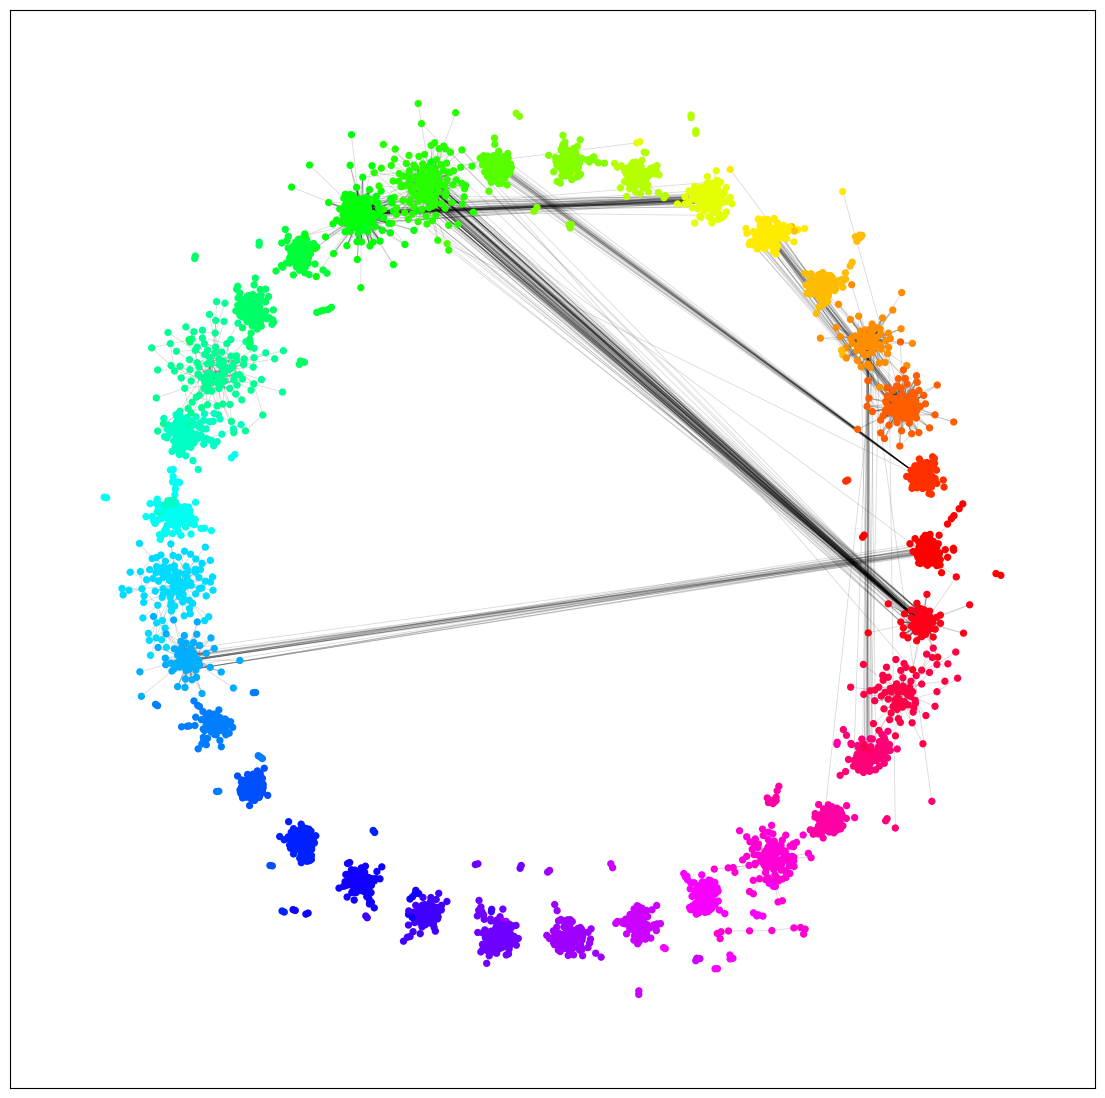

In [11]:
# Cell 5 — Plot Louvain communities (separated clusters, sampled, no isolates)

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

EDGES_COMPACT_PATH      = "edges_compact.parquet"
LOUVAIN_MEMBERSHIP_PATH = "louvain_membership.parquet"
LOUVAIN_SIZES_PATH      = "louvain_sizes.parquet"

# Controls
MAX_NODES_TOTAL   = 5000
MAX_EDGES_TOTAL   = 15000
MAX_PER_COMM      = 600
SEED              = 42
ANCHOR_RADIUS     = 12.0
CLUSTER_BASE_SIZE = 2.5
CLUSTER_SIZE_EXP  = 0.5

membership = pd.read_parquet(LOUVAIN_MEMBERSHIP_PATH, columns=["vertex","community"])
sizes      = pd.read_parquet(LOUVAIN_SIZES_PATH).sort_values("size", ascending=False)
edges      = pd.read_parquet(EDGES_COMPACT_PATH, columns=["src","dst","weight"])

# Ignore isolates globally (only nodes that appear in edges)
nodes_with_edges = pd.unique(edges[["src","dst"]].values.ravel())
membership = membership[membership["vertex"].isin(nodes_with_edges)]
sizes = membership.groupby("community").size().reset_index(name="size").sort_values("size", ascending=False)

communities = sizes["community"].to_list()
comm_sizes  = sizes["size"].to_numpy()

rng = np.random.default_rng(SEED)
target_per_comm = np.minimum(comm_sizes, MAX_PER_COMM).astype(int)
if target_per_comm.sum() > MAX_NODES_TOTAL:
    scale = MAX_NODES_TOTAL / target_per_comm.sum()
    target_per_comm = np.maximum((target_per_comm * scale).astype(int), 1)

selected_nodes = []
node_to_comm = {}
for comm, take_k in zip(communities, target_per_comm):
    mem = membership[membership["community"] == comm]["vertex"].to_numpy(dtype=np.int32)
    chosen = mem if len(mem) <= take_k else rng.choice(mem, size=take_k, replace=False)
    selected_nodes.append(chosen)
    for u in chosen:
        node_to_comm[u] = int(comm)

selected_nodes = np.unique(np.concatenate(selected_nodes))
sel_set = set(selected_nodes)

# Restrict to selected nodes and sample edges if needed
sub_edges = edges[edges["src"].isin(sel_set) & edges["dst"].isin(sel_set)]
if len(sub_edges) > MAX_EDGES_TOTAL:
    sub_edges = sub_edges.sample(n=MAX_EDGES_TOTAL, random_state=SEED)

# Final node set from sampled edges → guarantees no isolates
nodes_drawn = pd.unique(sub_edges[["src","dst"]].values.ravel())
draw_set = set(nodes_drawn)

# Build NX graph for visualization
G_vis = nx.Graph()
G_vis.add_nodes_from(draw_set)
G_vis.add_weighted_edges_from(sub_edges[["src","dst","weight"]].itertuples(index=False, name=None))

# Place each community at a different anchor on a big circle
present_comms = sorted(list({node_to_comm[u] for u in draw_set if u in node_to_comm}))
K = len(present_comms)
angles  = np.linspace(0, 2*np.pi, num=K, endpoint=False)
anchors = {c: np.array([ANCHOR_RADIUS*np.cos(a), ANCHOR_RADIUS*np.sin(a)]) for c, a in zip(present_comms, angles)}

cmap = plt.cm.get_cmap("tab20", K) if K <= 20 else plt.cm.get_cmap("hsv", K)
comm_to_color = {c: cmap(i) for i, c in enumerate(present_comms)}

pos = {}
max_comm_nodes = max([sum(1 for u in draw_set if node_to_comm.get(u)==c) for c in present_comms])
np.random.seed(SEED)
for c in present_comms:
    nodes_c = [u for u in draw_set if node_to_comm.get(u)==c]
    if not nodes_c:
        continue
    Gc = G_vis.subgraph(nodes_c)
    pos_local = nx.spring_layout(Gc, seed=SEED)
    pts = np.array(list(pos_local.values()))
    center = pts.mean(axis=0); pts -= center
    size_factor = (len(nodes_c)/max_comm_nodes)**CLUSTER_SIZE_EXP
    pts *= CLUSTER_BASE_SIZE * max(0.5, size_factor)
    pts += anchors[c]
    for node, p in zip(pos_local.keys(), pts):
        pos[node] = p

plt.figure(figsize=(14,14))
nx.draw_networkx_edges(G_vis, pos, alpha=0.15, width=0.6)
node_colors = [comm_to_color[node_to_comm.get(u, present_comms[0])] for u in G_vis.nodes]
nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=18)

# Short legend (top communities in the drawing)
present_counts = pd.Series([node_to_comm.get(u) for u in G_vis.nodes]).value_counts().reset_index()
present_counts.columns = ["community","count"]
present_counts = present_counts.sort_values("count", ascending=False)

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0],[0], marker='o', color='w',
           label=f"comm {int(c)} (n={int(cnt)})",
           markerfacecolor=comm_to_color[c], markersize=8)
    for c,cnt in present_counts.itertuples(index=False, name=None)[:15]
]
if legend_handles:
    plt.legend(handles=legend_handles, title="Communities (top shown)", loc="upper right", frameon=True)

plt.title(f"Louvain communities (GPU, separated) — nodes={G_vis.number_of_nodes():,}, edges={G_vis.number_of_edges():,}")
plt.axis("off"); plt.tight_layout(); plt.show()


In [12]:
import shutil, os

# Define where to save on Drive
DRIVE_DIR = "/content/drive/MyDrive/communities/results"
os.makedirs(DRIVE_DIR, exist_ok=True)

# List of files we want to preserve
FILES_TO_SAVE = [
    "edges_all.parquet",          # all raw edges
    "edges_compact.parquet",      # int32-coded edges
    "user_id_map.parquet",        # mapping code ↔ user_id
    "louvain_membership.parquet", # each vertex -> community
    "louvain_sizes.parquet",      # community sizes
    "louvain_meta.json"           # modularity & settings
]

# Copy files to Drive
for f in FILES_TO_SAVE:
    if os.path.exists(f):
        shutil.copy(f, DRIVE_DIR)
        print(f"✅ Copied {f} → {DRIVE_DIR}/")
    else:
        print(f"⚠️ Missing: {f} (not saved)")

print("\n💾 All outputs saved under:", DRIVE_DIR)


✅ Copied edges_all.parquet → /content/drive/MyDrive/communities/results/
✅ Copied edges_compact.parquet → /content/drive/MyDrive/communities/results/
✅ Copied user_id_map.parquet → /content/drive/MyDrive/communities/results/
✅ Copied louvain_membership.parquet → /content/drive/MyDrive/communities/results/
✅ Copied louvain_sizes.parquet → /content/drive/MyDrive/communities/results/
✅ Copied louvain_meta.json → /content/drive/MyDrive/communities/results/

💾 All outputs saved under: /content/drive/MyDrive/communities/results


In [13]:
# Cell 1 — Prune isolates from Louvain membership (keeps only nodes that appear in edges)
# Inputs:
#   - edges_compact.parquet       (src, dst, weight)
#   - louvain_membership.parquet  (vertex, community)
# Outputs:
#   - louvain_membership_pruned.parquet (vertex, community)
#   - louvain_sizes_pruned.parquet      (community, size)

import pandas as pd

EDGES_COMPACT_PATH      = "edges_compact.parquet"
LOUVAIN_MEMBERSHIP_PATH = "louvain_membership.parquet"

PRUNED_MEMBERSHIP_PATH  = "louvain_membership_pruned.parquet"
PRUNED_SIZES_PATH       = "louvain_sizes_pruned.parquet"

# Load
edges = pd.read_parquet(EDGES_COMPACT_PATH, columns=["src", "dst"])
membership = pd.read_parquet(LOUVAIN_MEMBERSHIP_PATH, columns=["vertex", "community"])

# Keep only vertices that appear in at least one edge
nodes_with_edges = pd.unique(edges[["src", "dst"]].values.ravel())
membership_pruned = membership[membership["vertex"].isin(nodes_with_edges)].copy()

# Recompute community sizes
sizes_pruned = (membership_pruned.groupby("community")
                .size().reset_index(name="size")
                .sort_values("size", ascending=False))

# Save
membership_pruned.to_parquet(PRUNED_MEMBERSHIP_PATH)
sizes_pruned.to_parquet(PRUNED_SIZES_PATH)

print(f"✅ Pruned membership → {PRUNED_MEMBERSHIP_PATH} (rows={len(membership_pruned):,})")
print(f"✅ Pruned sizes      → {PRUNED_SIZES_PATH} (communities={len(sizes_pruned):,})")


✅ Pruned membership → louvain_membership_pruned.parquet (rows=100,506)
✅ Pruned sizes      → louvain_sizes_pruned.parquet (communities=33)


In [14]:
# Cell 2 — Merge communities if they share more than MERGE_THRESHOLD inter-edges
# Hyperparameters:
MERGE_THRESHOLD = 100       # 👈 change this to any integer you want
USE_EDGE_WEIGHT = False    # if True, sum 'weight' instead of counting edges

# Inputs:
#   - edges_compact.parquet
#   - louvain_membership_pruned.parquet
# Outputs:
#   - louvain_membership_merged.parquet (vertex, community, merged_comm)
#   - louvain_sizes_merged.parquet      (merged_comm, size)
#   - community_links.parquet           (c_min, c_max, edges_between or weight_between)

import pandas as pd
import numpy as np
import networkx as nx

EDGES_COMPACT_PATH       = "edges_compact.parquet"
PRUNED_MEMBERSHIP_PATH   = "louvain_membership_pruned.parquet"

MERGED_MEMBERSHIP_PATH   = "louvain_membership_merged.parquet"
MERGED_SIZES_PATH        = "louvain_sizes_merged.parquet"
COMMUNITY_LINKS_PATH     = "community_links.parquet"

# Load
edges = pd.read_parquet(EDGES_COMPACT_PATH, columns=["src", "dst", "weight"])
memb  = pd.read_parquet(PRUNED_MEMBERSHIP_PATH, columns=["vertex", "community"])

# Map each endpoint to its community
edges = edges.merge(memb.rename(columns={"vertex":"src", "community":"comm_src"})[["src","comm_src"]],
                    on="src", how="left")
edges = edges.merge(memb.rename(columns={"vertex":"dst", "community":"comm_dst"})[["dst","comm_dst"]],
                    on="dst", how="left")

# Keep only inter-community edges
inter = edges[(edges["comm_src"].notna()) & (edges["comm_dst"].notna()) & (edges["comm_src"] != edges["comm_dst"])].copy()
inter["c_min"] = np.minimum(inter["comm_src"].astype(np.int64), inter["comm_dst"].astype(np.int64))
inter["c_max"] = np.maximum(inter["comm_src"].astype(np.int64), inter["comm_dst"].astype(np.int64))

# Aggregate between-community connectivity
if USE_EDGE_WEIGHT:
    comm_links = (inter.groupby(["c_min","c_max"])["weight"]
                  .sum().reset_index(name="between_strength"))
    metric_col = "between_strength"
else:
    comm_links = (inter.groupby(["c_min","c_max"])
                  .size().reset_index(name="edges_between"))
    metric_col = "edges_between"

# Save raw links for reference
comm_links.to_parquet(COMMUNITY_LINKS_PATH)
print(f"🔗 Saved community links → {COMMUNITY_LINKS_PATH} (rows={len(comm_links):,})")

# Build a community-graph with edges above the threshold
CG = nx.Graph()
CG.add_nodes_from(memb["community"].unique().tolist())

if USE_EDGE_WEIGHT:
    strong = comm_links[comm_links[metric_col] > MERGE_THRESHOLD]
else:
    strong = comm_links[comm_links[metric_col] > MERGE_THRESHOLD]

for _, r in strong.iterrows():
    CG.add_edge(int(r["c_min"]), int(r["c_max"]), weight=float(r[metric_col]))

# Connected components of CG define merged groups
merge_map = {}
for merged_id, comp in enumerate(nx.connected_components(CG)):
    for c in comp:
        merge_map[int(c)] = merged_id

# Assign merged labels
memb_merged = memb.copy()
memb_merged["merged_comm"] = memb_merged["community"].map(merge_map)

# Recompute merged sizes
sizes_merged = (memb_merged.groupby("merged_comm")
                .size().reset_index(name="size")
                .sort_values("size", ascending=False))

# Save
memb_merged.to_parquet(MERGED_MEMBERSHIP_PATH)
sizes_merged.to_parquet(MERGED_SIZES_PATH)

print(f"✅ Merged membership → {MERGED_MEMBERSHIP_PATH} (rows={len(memb_merged):,})")
print(f"✅ Merged sizes      → {MERGED_SIZES_PATH} (groups={len(sizes_merged):,})")
print(f"ℹ️ Merge rule: {'weight sum' if USE_EDGE_WEIGHT else 'edge count'} > {MERGE_THRESHOLD}")


🔗 Saved community links → community_links.parquet (rows=36)
✅ Merged membership → louvain_membership_merged.parquet (rows=100,506)
✅ Merged sizes      → louvain_sizes_merged.parquet (groups=18)
ℹ️ Merge rule: edge count > 100


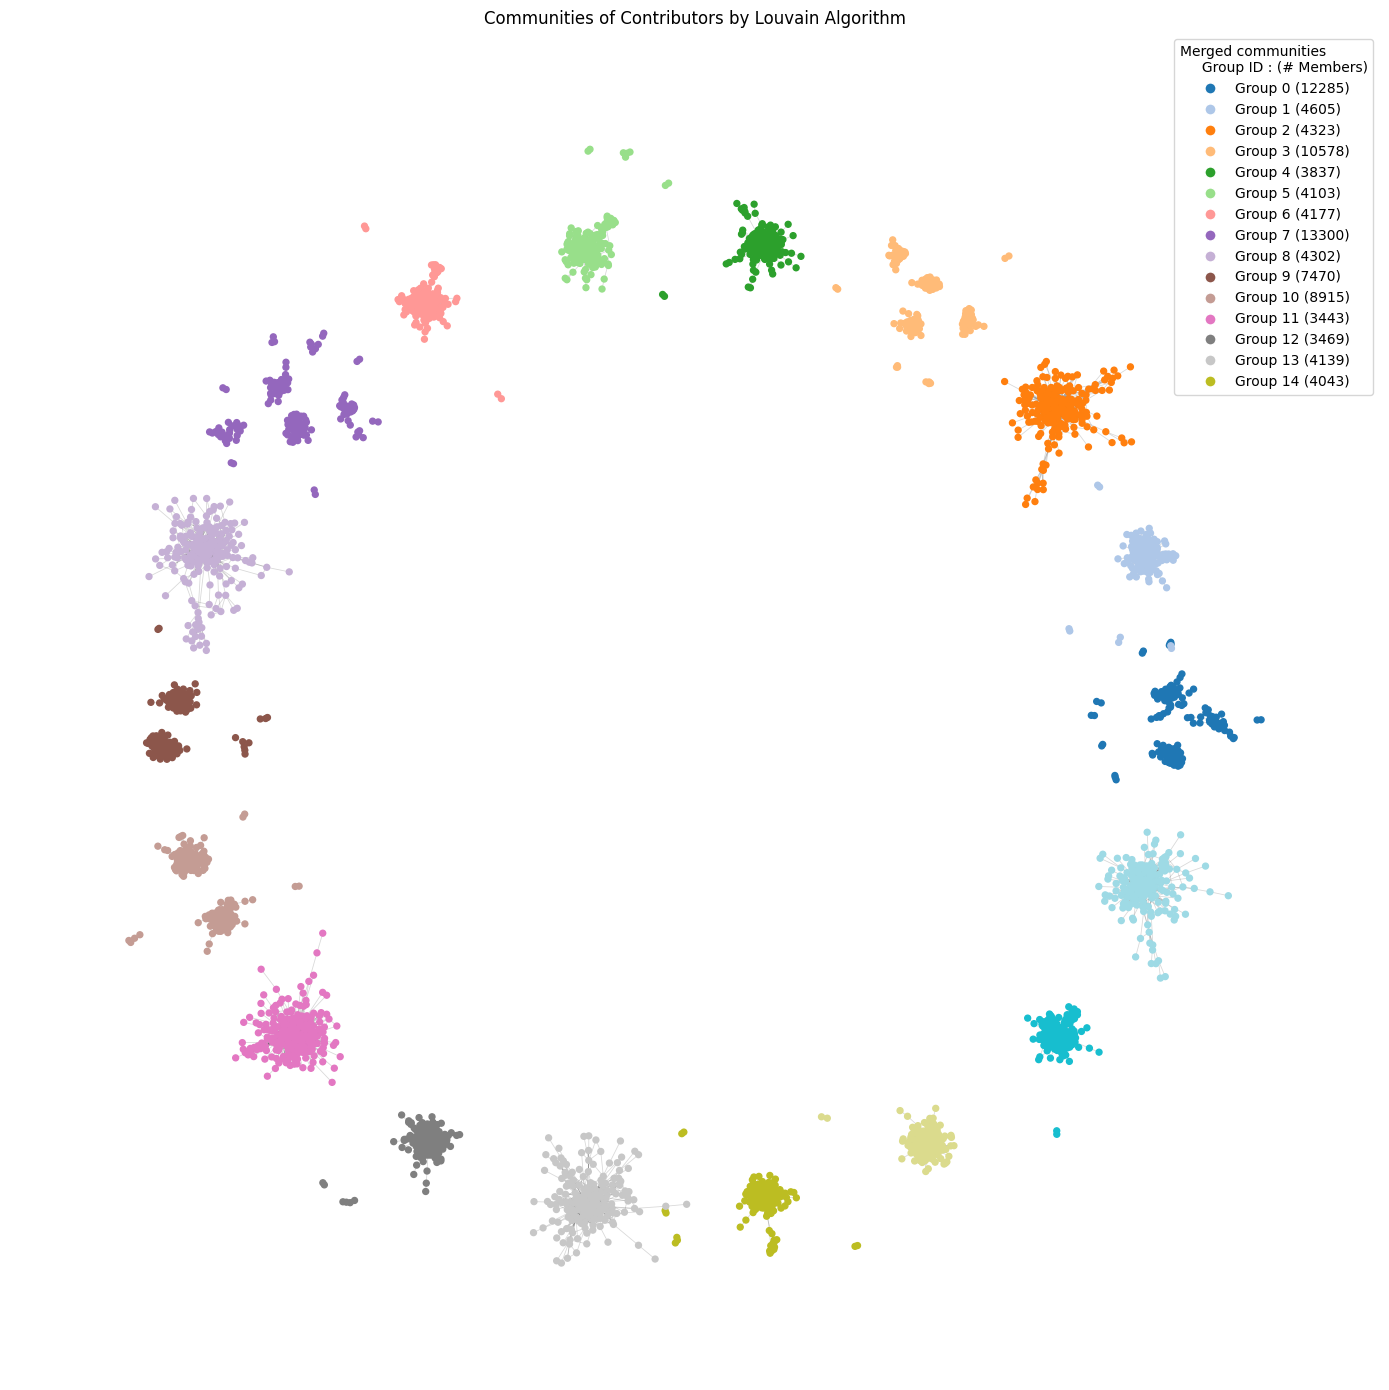

✅ Plot done with legend; isolates removed; communities merged by threshold.


In [15]:
# Cell 3 — Plot merged communities far apart, with legend (fixed)

# Inputs:
#   - edges_compact.parquet
#   - louvain_membership_merged.parquet

MAX_NODES_TOTAL   = 5000      # total nodes to draw (after sampling)
MAX_EDGES_TOTAL   = 15000     # total edges to draw (after sampling)
MAX_PER_COMM      = 600       # per community node cap
ANCHOR_RADIUS     = 12.0      # distance between community clusters
CLUSTER_BASE_SIZE = 2.5       # base intra-cluster scale
CLUSTER_SIZE_EXP  = 0.5       # cluster size ~ n_nodes**exp
SEED              = 42
LEGEND_TOPK       = 15        # how many communities to list in legend

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

EDGES_COMPACT_PATH      = "edges_compact.parquet"
MERGED_MEMBERSHIP_PATH  = "louvain_membership_merged.parquet"

edges = pd.read_parquet(EDGES_COMPACT_PATH, columns=["src","dst","weight"])
memb  = pd.read_parquet(MERGED_MEMBERSHIP_PATH, columns=["vertex","merged_comm"])

# Derive communities & sizes from merged labels
sizes = (memb.groupby("merged_comm")
         .size().reset_index(name="size")
         .sort_values("size", ascending=False))
communities = sizes["merged_comm"].to_list()
comm_sizes  = sizes["size"].to_numpy()

# Sampling nodes per community
rng = np.random.default_rng(SEED)
target_per_comm = np.minimum(comm_sizes, MAX_PER_COMM).astype(int)
if target_per_comm.sum() > MAX_NODES_TOTAL:
    scale = MAX_NODES_TOTAL / target_per_comm.sum()
    target_per_comm = np.maximum((target_per_comm * scale).astype(int), 1)

node_to_comm = {}
selected_nodes = []
for comm, take_k in zip(communities, target_per_comm):
    members = memb[memb["merged_comm"] == comm]["vertex"].to_numpy(dtype=np.int32)
    if len(members) == 0:
        continue
    chosen = members if len(members) <= take_k else rng.choice(members, size=take_k, replace=False)
    selected_nodes.append(chosen)
    for u in chosen:
        node_to_comm[u] = int(comm)

if len(selected_nodes) == 0:
    raise RuntimeError("Sampling produced zero nodes. Increase MAX_NODES_TOTAL or MAX_PER_COMM.")

selected_nodes = np.unique(np.concatenate(selected_nodes))
sel_set = set(selected_nodes)

# Keep only edges within selected nodes, then sample edges globally
sub_edges = edges[edges["src"].isin(sel_set) & edges["dst"].isin(sel_set)]
if len(sub_edges) == 0:
    raise RuntimeError("No edges between selected nodes. Increase MAX_NODES_TOTAL/MAX_PER_COMM or lower sampling.")
if len(sub_edges) > MAX_EDGES_TOTAL:
    sub_edges = sub_edges.sample(n=MAX_EDGES_TOTAL, random_state=SEED)

# Final nodes from these edges ensure no isolates in the plot
nodes_drawn = pd.unique(sub_edges[["src","dst"]].values.ravel())
draw_set = set(nodes_drawn)

# Build small visualization graph
G_vis = nx.Graph()
G_vis.add_nodes_from(draw_set)
G_vis.add_weighted_edges_from(sub_edges[["src","dst","weight"]].itertuples(index=False, name=None))

# Separate clusters by placing each community at an anchor on a big circle
present_comms = sorted(list({node_to_comm[u] for u in draw_set if u in node_to_comm}))
K = len(present_comms)
angles  = np.linspace(0, 2*np.pi, num=max(K,1), endpoint=False)
anchors = {c: np.array([ANCHOR_RADIUS*np.cos(a), ANCHOR_RADIUS*np.sin(a)]) for c, a in zip(present_comms, angles)}

# Colors (new API)
cmap = plt.colormaps.get_cmap("tab20") if K <= 20 else plt.colormaps.get_cmap("hsv")
comm_to_color = {c: cmap(i / max(1, K-1)) for i, c in enumerate(present_comms)}

# Compute positions: layout each community locally, rescale, then translate to its anchor
pos = {}
max_comm_nodes = max([sum(1 for u in draw_set if node_to_comm.get(u)==c) for c in present_comms]) if K else 1
np.random.seed(SEED)
for c in present_comms:
    nodes_c = [u for u in draw_set if node_to_comm.get(u)==c]
    if not nodes_c:
        continue
    Gc = G_vis.subgraph(nodes_c)
    pos_local = nx.spring_layout(Gc, seed=SEED)
    pts = np.array(list(pos_local.values()))
    if len(pts) == 0:
        continue
    center = pts.mean(axis=0); pts -= center
    size_factor = (len(nodes_c)/max_comm_nodes)**CLUSTER_SIZE_EXP
    pts *= CLUSTER_BASE_SIZE * max(0.5, size_factor)
    pts += anchors[c]
    for node, p in zip(pos_local.keys(), pts):
        pos[node] = p

# If something slipped through and a node has no pos, give it a random near the center
for n in G_vis.nodes:
    if n not in pos:
        pos[n] = (rng.normal(0, 0.1), rng.normal(0, 0.1))

# Draw edges and nodes
plt.figure(figsize=(14,14))
nx.draw_networkx_edges(G_vis, pos, alpha=0.15, width=0.6)
node_colors = [comm_to_color.get(node_to_comm.get(u, present_comms[0] if K else 0),
                                 (0.7,0.7,0.7,1)) for u in G_vis.nodes]
nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=18)

# Legend (top communities by presence in the drawing)
present_counts = pd.Series([node_to_comm.get(u) for u in G_vis.nodes]).value_counts().reset_index()
present_counts.columns = ["merged_comm","count"]
present_counts = present_counts.sort_values("count", ascending=False)

# === Legend (only change) ===
# Numeric order by community id; label as "Group i (members)" with full global size
from matplotlib.lines import Line2D

sizes_full = memb.groupby("merged_comm").size().astype(int)  # global member counts
size_map = sizes_full.to_dict()

legend_comms = sorted(present_comms)[:LEGEND_TOPK]
legend_handles = [
    Line2D([0],[0], marker='o', color='w',
           label=f"Group {int(c)} ({int(size_map.get(int(c), 0))})",
           markerfacecolor=comm_to_color.get(c, (0.6,0.6,0.6,1)), markersize=8)
    for c in legend_comms
]
if legend_handles:
    plt.legend(
        handles=legend_handles,
        title="Merged communities\n     Group ID : (# Members)",
        loc="upper right",
        frameon=True
    )


plt.title("Communities of Contributors by Louvain Algorithm")
plt.axis("off"); plt.tight_layout(); plt.show()

print("✅ Plot done with legend; isolates removed; communities merged by threshold.")


In [16]:
# Cell — Save CURRENT (pruned + merged) communities to a NEW folder on Drive

import os, shutil, time, json
from pathlib import Path

# Where to save on Drive
BASE_DRIVE = Path("/content/drive/MyDrive/communities")
STAMP = time.strftime("%Y%m%d-%H%M%S")
SAVE_DIR = BASE_DRIVE / f"results_merged_{STAMP}"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Inputs produced by the previous cells
FILES = {
    "membership_pruned": "louvain_membership_pruned.parquet",
    "sizes_pruned":      "louvain_sizes_pruned.parquet",
    "membership_merged": "louvain_membership_merged.parquet",
    "sizes_merged":      "louvain_sizes_merged.parquet",
    "community_links":   "community_links.parquet",      # between-community edges used for merging
    # Optional references (uncomment if you also want these copied)
    # "edges_compact":     "edges_compact.parquet",
    # "user_id_map":       "user_id_map.parquet",
}

# Copy any that exist
copied = []
missing = []
for label, src in FILES.items():
    if os.path.exists(src):
        shutil.copy(src, SAVE_DIR / Path(src).name)
        copied.append(src)
    else:
        missing.append(src)

# Save a tiny manifest with context
manifest = {
    "saved_at": STAMP,
    "save_dir": str(SAVE_DIR),
    "copied_files": copied,
    "missing_files": missing,
    # If you used these in Cell 2, record them (won't error if undefined)
    "merge_params": {
        "MERGE_THRESHOLD": globals().get("MERGE_THRESHOLD", None),
        "USE_EDGE_WEIGHT": globals().get("USE_EDGE_WEIGHT", None),
    },
}
with open(SAVE_DIR / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("✅ Saved current communities to:", SAVE_DIR)
print("   Copied:", copied)
if missing:
    print("   ⚠️ Missing (not copied):", missing)


✅ Saved current communities to: /content/drive/MyDrive/communities/results_merged_20250820-165627
   Copied: ['louvain_membership_pruned.parquet', 'louvain_sizes_pruned.parquet', 'louvain_membership_merged.parquet', 'louvain_sizes_merged.parquet', 'community_links.parquet']


In [17]:
# Try to locate user_id_map.parquet anywhere under your Drive "communities" folder,
# then create note_communities.{parquet,csv} → [community_id, noteId]

from pathlib import Path
import glob
import pandas as pd

BASE = Path("/content/drive/MyDrive/communities")
RESULTS_DIR = BASE / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Try to find a user_id_map.parquet
candidates = list(BASE.rglob("user_id_map.parquet"))
if candidates:
    USER_ID_MAP_PATH = candidates[0]
    print("✅ Found user_id_map at:", USER_ID_MAP_PATH)
else:
    USER_ID_MAP_PATH = None
    print("❌ user_id_map.parquet not found anywhere under", BASE)

# 2) If found, build note → community mapping from *merged* membership
if USER_ID_MAP_PATH is not None:
    MEMBERSHIP_MERGED_PATH = Path("louvain_membership_merged.parquet")
    if not MEMBERSHIP_MERGED_PATH.exists():
        raise FileNotFoundError("louvain_membership_merged.parquet not found in the working directory.")

    # load membership (vertex codes -> merged_comm)
    memb = pd.read_parquet(MEMBERSHIP_MERGED_PATH, columns=["vertex", "merged_comm"])

    # map codes -> participantId
    idmap = pd.read_parquet(USER_ID_MAP_PATH, columns=["code", "user_id"])

    memb_pid = (memb.merge(idmap, left_on="vertex", right_on="code", how="left")
                     [["user_id", "merged_comm"]]
                     .dropna(subset=["user_id"])
                     .drop_duplicates("user_id")
                     .rename(columns={"user_id": "participantId", "merged_comm": "community_id"}))
    print(f"Membership rows (unique participantId): {len(memb_pid):,}")

    # find notes-*.tsv in same tree
    note_globs = [
        str(BASE / "notes-*.tsv"),
        str(BASE / "Notes-*.tsv"),
        str(BASE / "raw/notes-*.tsv"),
        str(BASE / "raw/Notes-*.tsv"),
    ]
    note_files = sorted({p for pat in note_globs for p in glob.glob(pat)})
    if not note_files:
        raise FileNotFoundError("No notes-*.tsv found under the communities folder.")

    print("Found notes files:")
    for f in note_files[:10]:
        print("  •", f)
    if len(note_files) > 10:
        print(f"  … and {len(note_files)-10} more")

    # stream notes → join by participantId → keep one row per noteId
    chunksize = 1_000_000
    partials = []
    for nf in note_files:
        print("Reading:", nf)
        for chunk in pd.read_csv(
            nf,
            sep="\t",
            usecols=["noteId", "noteAuthorParticipantId"],
            dtype={"noteId": str, "noteAuthorParticipantId": str},
            chunksize=chunksize
        ):
            joined = (
                chunk.merge(
                    memb_pid,
                    left_on="noteAuthorParticipantId",   # join on author
                    right_on="participantId",
                    how="left"
                )[["noteId", "community_id"]]
                .dropna(subset=["community_id"])
                .drop_duplicates(subset=["noteId"])
            )
            partials.append(joined)

    note_comms = (
        pd.concat(partials, ignore_index=True)
          .drop_duplicates(subset=["noteId"])
          [["community_id", "noteId"]]
    )

    out_parquet = RESULTS_DIR / "note_communities.parquet"
    out_csv     = RESULTS_DIR / "note_communities.csv"
    note_comms.to_parquet(out_parquet, index=False)
    note_comms.to_csv(out_csv, index=False)

    print("\n✅ Saved:")
    print(" ", out_parquet, f"(rows={len(note_comms):,})")
    print(" ", out_csv,     f"(rows={len(note_comms):,})")


✅ Found user_id_map at: /content/drive/MyDrive/communities/results_0/user_id_map.parquet
Membership rows (unique participantId): 100,506
Found notes files:
  • /content/drive/MyDrive/communities/notes-00000.tsv
Reading: /content/drive/MyDrive/communities/notes-00000.tsv

✅ Saved:
  /content/drive/MyDrive/communities/results/note_communities.parquet (rows=160,090)
  /content/drive/MyDrive/communities/results/note_communities.csv (rows=160,090)


In [18]:
from pathlib import Path
import pandas as pd

BASE = Path("/content/drive/MyDrive/communities")
RESULTS_DIR = BASE / "results"
NOTE_COMMS = RESULTS_DIR / "note_communities.parquet"

df = pd.read_parquet(NOTE_COMMS)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

nulls = df.isna().sum()
print("\nNulls:\n", nulls)

dups = df.duplicated(subset=["noteId"]).sum()
print("\nDuplicate noteId rows:", dups)

print("\nTop 10 communities by note count:")
print(df["community_id"].value_counts().head(10))


Rows: 160090
Columns: ['community_id', 'noteId']

Nulls:
 community_id    0
noteId          0
dtype: int64

Duplicate noteId rows: 0

Top 10 communities by note count:
community_id
7.0     24061
0.0     17706
3.0     14035
10.0    13030
9.0     10989
13.0     9141
8.0      8912
14.0     8014
1.0      7330
6.0      6765
Name: count, dtype: int64


In [19]:
from pathlib import Path
import glob
import pandas as pd

BASE = Path("/content/drive/MyDrive/communities")
RESULTS_DIR = BASE / "results"
NOTE_COMMS = RESULTS_DIR / "note_communities.parquet"

note_files = sorted({
    *glob.glob(str(BASE / "notes-*.tsv")),
    *glob.glob(str(BASE / "Notes-*.tsv")),
    *glob.glob(str(BASE / "raw/notes-*.tsv")),
    *glob.glob(str(BASE / "raw/Notes-*.tsv")),
})

total_notes = set()
for nf in note_files:
    for chunk in pd.read_csv(nf, sep="\t", usecols=["noteId"], dtype={"noteId": str}, chunksize=1_000_000):
        total_notes.update(chunk["noteId"].tolist())

total_notes_count = len(total_notes)
mapped = pd.read_parquet(NOTE_COMMS)
mapped_count = mapped["noteId"].nunique()

print("Total distinct notes found:", f"{total_notes_count:,}")
print("Notes with author community:", f"{mapped_count:,}")
if total_notes_count:
    print("Coverage:", f"{mapped_count/total_notes_count:.2%}")


Total distinct notes found: 2,038,017
Notes with author community: 160,090
Coverage: 7.86%


In [20]:
# Build note → community_id using rater communities (majority community per note)
# Outputs:
#   results/note_communities_raters.parquet (community_id, noteId)

from pathlib import Path
import pandas as pd
import numpy as np
import glob

BASE = Path("/content/drive/MyDrive/communities")
RESULTS_DIR = BASE / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Use the same merged membership you already have
MEMBERSHIP_MERGED_PATH = Path("louvain_membership_merged.parquet")
USER_ID_MAP_PATH = sorted(BASE.rglob("user_id_map.parquet"))[0]  # we know this exists from your last run

# Ratings files (same place as notes)
ratings_files = sorted({
    *glob.glob(str(BASE / "ratings-*.tsv")),
    *glob.glob(str(BASE / "Ratings-*.tsv")),
    *glob.glob(str(BASE / "raw/ratings-*.tsv")),
    *glob.glob(str(BASE / "raw/Ratings-*.tsv")),
})
if not ratings_files:
    raise FileNotFoundError("No ratings-*.tsv files found under your communities folder.")

# Load membership (vertex → merged_comm) and map to participantId
memb = pd.read_parquet(MEMBERSHIP_MERGED_PATH, columns=["vertex", "merged_comm"])
idmap = pd.read_parquet(USER_ID_MAP_PATH, columns=["code","user_id"])
memb_pid = (memb.merge(idmap, left_on="vertex", right_on="code", how="left")
                 [["user_id","merged_comm"]]
                 .dropna(subset=["user_id"])
                 .drop_duplicates("user_id")
                 .rename(columns={"user_id":"raterParticipantId","merged_comm":"community_id"}))

# Accumulate per-chunk counts: (noteId, community_id) → count
partials = []
for rf in ratings_files:
    print("Reading ratings:", rf)
    for chunk in pd.read_csv(
        rf, sep="\t",
        usecols=["noteId","raterParticipantId"],
        dtype={"noteId": str, "raterParticipantId": str},
        chunksize=1_000_000
    ):
        joined = chunk.merge(memb_pid, on="raterParticipantId", how="left").dropna(subset=["community_id"])
        if joined.empty:
            continue
        # Count votes per (noteId, community_id)
        counts = (joined.groupby(["noteId","community_id"])
                        .size().reset_index(name="votes"))
        partials.append(counts)

if not partials:
    raise RuntimeError("No rater communities matched. Make sure membership aligns with ratings build.")

# Combine all partials, then take majority community per note
all_counts = pd.concat(partials, ignore_index=True)
all_counts = (all_counts.groupby(["noteId","community_id"])["votes"].sum()
                      .reset_index())

# For each note, choose community with max votes; tie-breaker = smallest community_id
all_counts.sort_values(["noteId","votes","community_id"], ascending=[True,False,True], inplace=True)
majority = all_counts.groupby("noteId", as_index=False).first()[["community_id","noteId"]]

out_parquet = RESULTS_DIR / "note_communities_raters.parquet"
out_csv     = RESULTS_DIR / "note_communities_raters.csv"
majority.to_parquet(out_parquet, index=False)
majority.to_csv(out_csv, index=False)

print("✅ Saved rater-majority note communities:")
print(" ", out_parquet, f"(rows={len(majority):,})")
print(" ", out_csv,     f"(rows={len(majority):,})")


Reading ratings: /content/drive/MyDrive/communities/ratings-00000.tsv
Reading ratings: /content/drive/MyDrive/communities/ratings-00001.tsv
Reading ratings: /content/drive/MyDrive/communities/ratings-00006.tsv
Reading ratings: /content/drive/MyDrive/communities/ratings-00007.tsv
Reading ratings: /content/drive/MyDrive/communities/ratings-00009.tsv
✅ Saved rater-majority note communities:
  /content/drive/MyDrive/communities/results/note_communities_raters.parquet (rows=1,511,348)
  /content/drive/MyDrive/communities/results/note_communities_raters.csv (rows=1,511,348)


In [8]:
# Cell PR-1 — Global weighted PageRank on the contributor graph (GPU)

import cudf, cugraph
import pandas as pd
from pathlib import Path
import gc

# Inputs (already produced in your pipeline)
EDGES_COMPACT_PATH = "/content/drive/MyDrive/communities/results/edges_compact.parquet"          # columns: src, dst, weight
USER_ID_MAP_SEARCH = "/content/drive/MyDrive/communities/results"  # optional, for mapping codes -> participantId

# Outputs
PR_GLOBAL_PATH         = "pagerank_global.parquet"            # vertex (int32), pagerank (float)
PR_GLOBAL_WITH_IDS_PATH= "pagerank_global_with_ids.parquet"   # participantId (str), pagerank (float)

# Build cuGraph graph
edges_gdf = cudf.read_parquet(EDGES_COMPACT_PATH)
G = cugraph.Graph(directed=False)
G.from_cudf_edgelist(edges_gdf, source="src", destination="dst", edge_attr="weight", renumber=False)
print("✅ Graph ready:", G.number_of_vertices(), "vertices;", G.number_of_edges(), "edges")

# Run weighted PageRank (alpha=0.85 by default)
pr = cugraph.pagerank(G, alpha=0.85, max_iter=100, tol=1e-06, weight="weight")
# normalize column name across versions
if "pagerank" not in pr.columns:
    pr = pr.rename(columns={pr.columns[-1]: "pagerank"})

# Save (codes only)
pr.to_parquet(PR_GLOBAL_PATH)
print(f"💾 Saved global PageRank → {PR_GLOBAL_PATH} (rows={len(pr):,})")

# Optionally, also save with participantId if we can find the id map
from glob import glob
id_map_candidates = glob(str(Path(USER_ID_MAP_SEARCH) / "**/user_id_map.parquet"), recursive=True)
if id_map_candidates:
    id_map_path = id_map_candidates[0]
    idmap = pd.read_parquet(id_map_path, columns=["code","user_id"])
    out = pr.to_pandas().merge(idmap, left_on="vertex", right_on="code", how="left")[["user_id","pagerank"]]
    out = out.rename(columns={"user_id":"participantId"})
    out.to_parquet(PR_GLOBAL_WITH_IDS_PATH, index=False)
    print(f"💾 Saved global PageRank (with participantId) → {PR_GLOBAL_WITH_IDS_PATH} (rows={len(out):,})")
else:
    print("ℹ️ user_id_map.parquet not found — skipped the participantId version.")

# Show top-10 (if idmap present)
if id_map_candidates:
    top10 = out.sort_values("pagerank", ascending=False).head(10)
    print("\nTop-10 by PageRank:")
    display(top10)
del edges_gdf, G; gc.collect()


✅ Graph ready: 500033 vertices; 23091540 edges


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


💾 Saved global PageRank → pagerank_global.parquet (rows=500,033)
💾 Saved global PageRank (with participantId) → pagerank_global_with_ids.parquet (rows=500,033)

Top-10 by PageRank:


,participantId,pagerank
0,049E9E249CF132BD220934A2301413303C9F83D5CC0D86...,0.000330
1,E848DB71A10D211C7BC9CC031153C01CD56F146C772D00...,0.000270
16,F2BCC6C60FDD8CAF901E652FE6D8157DD3BDAD65F623A3...,0.000260
14,C95EBD8244228DFF8C11CCEEFFA46E8F210C020D403407...,0.000226
7,CA13806B4DBB8C01F033A0DC988A4450E9C685A8E3C5E9...,0.000222
31,6779E0AAD43619714067981E6F9DF2B436D141CED221F3...,0.000220
2,851BEEBE6F7D80CD0243575B4498DA97DC572736A9109F...,0.000218
17,12440F70709BC2ACDAFB6BDF47C3E1EC36A05E3D2C57F3...,0.000215
12,BF7BE8C9B9536147E161FBBC4498DBC7640799456BB466...,0.000210
9,F133624BEE35ECC2B69B0D3FFF5720C6AC3335E8D19FBC...,0.000208


665

In [14]:
# Controls
TOP_K_COMMS   = None   # e.g., 20 to limit to top-20 largest communities; None = all
MIN_COMM_SIZE = 5      # skip tiny communities to save time

# Outputs
PR_COMM_PATH          = "pagerank_by_community.parquet"             # vertex, community, pagerank
PR_COMM_WITH_IDS_PATH = "pagerank_by_community_with_ids.parquet"    # participantId, community, pagerank

# --- Load edges
edges_gdf = cudf.read_parquet(EDGES_COMPACT_PATH)[["src","dst","weight"]]

# --- Load membership and detect the community column
memb_raw = cudf.read_parquet(MEMBERSHIP_PATH)

# Detect vertex column
vertex_col = None
for cand in ["vertex", "node", "id", "src"]:  # most exports use "vertex"
    if cand in memb_raw.columns:
        vertex_col = cand
        break
if vertex_col is None:
    raise KeyError(f"Could not find a vertex column in {MEMBERSHIP_PATH}. Saw: {list(memb_raw.columns)}")

# Detect community/partition column
comm_col = None
for cand in ["community", "merged_comm", "partition", "partition_key", "label"]:
    if cand in memb_raw.columns:
        comm_col = cand
        break
if comm_col is None:
    raise KeyError(
        "Could not find a community label column in the membership file. "
        f"Saw columns: {list(memb_raw.columns)}. Expected one of: "
        "community, merged_comm, partition, partition_key, label"
    )

# Normalize to expected names: vertex, community
memb_gdf = memb_raw[[vertex_col, comm_col]].rename(columns={vertex_col: "vertex", comm_col: "community"})

# --- Decide which communities to run
sizes = (memb_gdf.groupby("community")
         .size()
         .reset_index(name="size")
         .sort_values("size", ascending=False))
if TOP_K_COMMS is not None:
    keep = sizes.head(TOP_K_COMMS)
else:
    keep = sizes
keep = keep[keep["size"] >= MIN_COMM_SIZE]
comm_list = keep["community"].to_pandas().tolist()
print(f"Will compute PageRank for {len(comm_list)} communities (min size {MIN_COMM_SIZE}).")

# --- Build a base graph and run PR per community
G_base = cugraph.Graph(directed=False)
G_base.from_cudf_edgelist(edges_gdf, source="src", destination="dst", edge_attr="weight", renumber=False)

all_parts = []
for c in comm_list:
    verts = memb_gdf[memb_gdf["community"] == c][["vertex"]]
    if len(verts) < MIN_COMM_SIZE:
        continue
    # cugraph.subgraph signature can differ across versions
    try:
        SG = cugraph.subgraph(G_base, verts["vertex"])
    except TypeError:
        SG, _ = cugraph.subgraph(G_base, verts["vertex"])
    if SG.number_of_edges() == 0:
        continue

    pr_c = cugraph.pagerank(SG, alpha=0.85, max_iter=100, tol=1e-06, weight="weight")
    if "pagerank" not in pr_c.columns:
        pr_c = pr_c.rename(columns={pr_c.columns[-1]: "pagerank"})
    pr_c["community"] = c
    all_parts.append(pr_c[["vertex","community","pagerank"]])
    print(f"  ✅ community {int(c)}: nodes={SG.number_of_vertices()}, edges={SG.number_of_edges()}")

# --- Save
if not all_parts:
    raise RuntimeError("No communities produced PageRank results (check sizes/filters).")

pr_comm = cudf.concat(all_parts, ignore_index=True)
pr_comm.to_parquet(PR_COMM_PATH)
print(f"💾 Saved per-community PageRank → {PR_COMM_PATH} (rows={len(pr_comm):,})")

# Optional participantId version
from glob import glob
id_map_candidates = glob(str(Path(USER_ID_MAP_SEARCH) / "**/user_id_map.parquet"), recursive=True)
if id_map_candidates:
    id_map_path = id_map_candidates[0]
    idmap = pd.read_parquet(id_map_path, columns=["code","user_id"])
    out = pr_comm.to_pandas().merge(idmap, left_on="vertex", right_on="code", how="left")[["user_id","community","pagerank"]]
    out = out.rename(columns={"user_id":"participantId"})
    out.to_parquet(PR_COMM_WITH_IDS_PATH, index=False)
    print(f"💾 Saved per-community PageRank (with participantId) → {PR_COMM_WITH_IDS_PATH} (rows={len(out):,})")
else:
    print("ℹ️ user_id_map.parquet not found — skipped the participantId version.")

del edges_gdf, memb_gdf, memb_raw, G_base; gc.collect()

Will compute PageRank for 33 communities (min size 5).


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


  ✅ community 13: nodes=4661, edges=222406
  ✅ community 23: nodes=4605, edges=209550
  ✅ community 22: nodes=4323, edges=198327
  ✅ community 27: nodes=4302, edges=190077


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


  ✅ community 26: nodes=4254, edges=202096
  ✅ community 17: nodes=4245, edges=189043
  ✅ community 8: nodes=4177, edges=177660
  ✅ community 28: nodes=4139, edges=196102


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


  ✅ community 25: nodes=4103, edges=176875
  ✅ community 24: nodes=4067, edges=179499


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


  ✅ community 12: nodes=4043, edges=179449
  ✅ community 16: nodes=3973, edges=172303
  ✅ community 15: nodes=3943, edges=169283


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr

  ✅ community 14: nodes=3837, edges=173451
  ✅ community 21: nodes=3527, edges=151398
  ✅ community 7: nodes=3500, edges=177931
  ✅ community 19: nodes=3469, edges=161844
  ✅ community 4: nodes=3428, edges=147875
  ✅ community 30: nodes=3172, edges=130189


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr

  ✅ community 1: nodes=3124, edges=157457
  ✅ community 6: nodes=3120, edges=126486
  ✅ community 0: nodes=3078, edges=141882
  ✅ community 5: nodes=3073, edges=127551
  ✅ community 29: nodes=3053, edges=135594
  ✅ community 9: nodes=2864, edges=185409


/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr

  ✅ community 10: nodes=2223, edges=162310
  ✅ community 20: nodes=2107, edges=132612
  ✅ community 11: nodes=531, edges=37786
  ✅ community 31: nodes=450, edges=2811
  ✅ community 2: nodes=343, edges=17801
  ✅ community 3: nodes=271, edges=9719
  ✅ community 32: nodes=260, edges=12313
  ✅ community 18: nodes=241, edges=7740
💾 Saved per-community PageRank → pagerank_by_community.parquet (rows=100,506)
💾 Saved per-community PageRank (with participantId) → pagerank_by_community_with_ids.parquet (rows=100,506)


1598

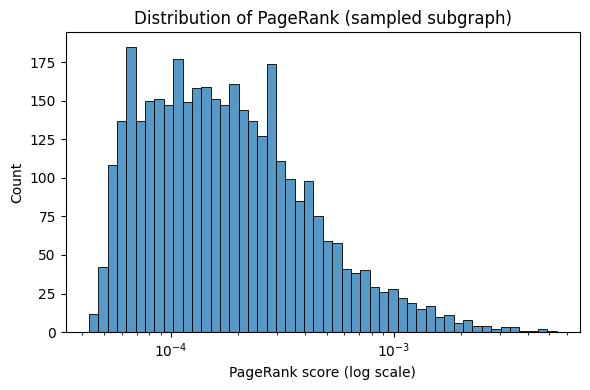

/tmp/ipython-input-1008469721.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_comms, x="community", y="pagerank", palette="viridis")


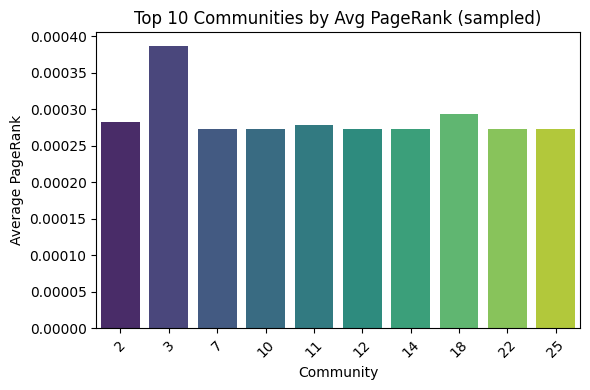

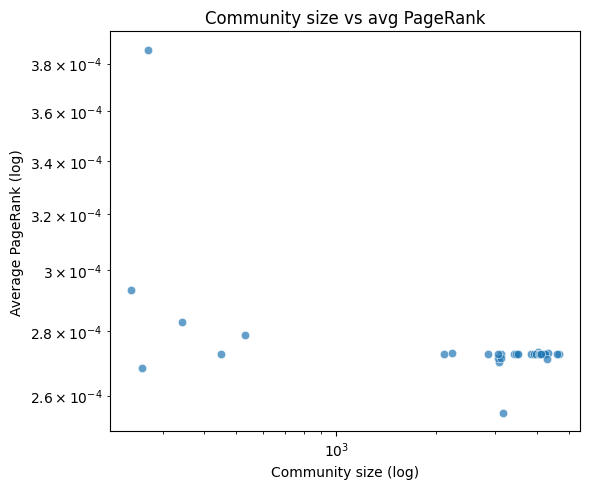

🔝 Top 20 nodes by PageRank (sampled subgraph):
 vertex  pagerank  community
 459543  0.005397         29
 248124  0.004657         12
 345790  0.004571         29
 379127  0.004088         21
 200349  0.003719         23
  12480  0.003664         16
  84601  0.003353         12
  13165  0.003352         25
 109131  0.003176          0
 450728  0.003134          4
 264759  0.003112         12
 300506  0.002881         12
 396055  0.002869         28
 387377  0.002727         15
 463017  0.002709         26
 498963  0.002690         17
 445351  0.002544         12
 478698  0.002463          1
 408774  0.002447         17
  87879  0.002416         29


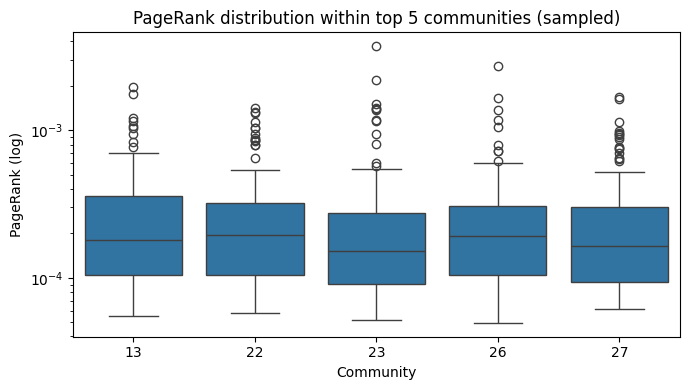

In [19]:
# --- PageRank analysis on sampled subgraph (lighter) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

RESULTS_DIR = "/content/drive/MyDrive/communities/results"
MEMBERSHIP_PATH = f"{RESULTS_DIR}/louvain_membership.parquet"
EDGES_COMPACT_PATH = f"{RESULTS_DIR}/edges_compact.parquet"

# Parameters for sampling
MAX_NODES_TOTAL = 5000
MAX_EDGES_TOTAL = 15000
SEED = 42

# Load membership + edges
memb = pd.read_parquet(MEMBERSHIP_PATH)[["vertex","community"]]
edges = pd.read_parquet(EDGES_COMPACT_PATH, columns=["src","dst","weight"])

# --- Sample nodes and edges to reduce size ---
rng = np.random.default_rng(SEED)
nodes_sample = rng.choice(memb["vertex"].unique(), size=min(MAX_NODES_TOTAL, len(memb)), replace=False)
nodes_set = set(nodes_sample)

edges_sub = edges[edges["src"].isin(nodes_set) & edges["dst"].isin(nodes_set)]
if len(edges_sub) > MAX_EDGES_TOTAL:
    edges_sub = edges_sub.sample(n=MAX_EDGES_TOTAL, random_state=SEED)

# --- Build smaller graph ---
G = nx.Graph()
G.add_weighted_edges_from(edges_sub[["src","dst","weight"]].itertuples(index=False, name=None))

# --- Compute PageRank on subgraph ---
pr = nx.pagerank(G, alpha=0.85, max_iter=100)
pagerank_df = pd.DataFrame(list(pr.items()), columns=["vertex","pagerank"])

# Merge with membership
pr_with_comm = pagerank_df.merge(memb, on="vertex", how="left")

# --- 1. Distribution of PageRank (log-scale) ---
plt.figure(figsize=(6,4))
sns.histplot(pr_with_comm["pagerank"], bins=50, log_scale=True)
plt.xlabel("PageRank score (log scale)")
plt.ylabel("Count")
plt.title("Distribution of PageRank (sampled subgraph)")
plt.tight_layout()
plt.show()

# --- 2. Top communities by average PageRank ---
comm_avg = pr_with_comm.groupby("community")["pagerank"].mean().reset_index()
top_comms = comm_avg.sort_values("pagerank", ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(data=top_comms, x="community", y="pagerank", palette="viridis")
plt.title("Top 10 Communities by Avg PageRank (sampled)")
plt.ylabel("Average PageRank")
plt.xlabel("Community")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 3. Scatter: community size vs avg PageRank ---
comm_sizes = memb.groupby("community").size().reset_index(name="size")
comm_stats = comm_avg.merge(comm_sizes, on="community")
plt.figure(figsize=(6,5))
sns.scatterplot(data=comm_stats, x="size", y="pagerank", alpha=0.7)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Community size (log)")
plt.ylabel("Average PageRank (log)")
plt.title("Community size vs avg PageRank")
plt.tight_layout()
plt.show()

# --- 4. Top-k nodes by PageRank ---
topk = 20
top_nodes = pr_with_comm.sort_values("pagerank", ascending=False).head(topk)
print(f"🔝 Top {topk} nodes by PageRank (sampled subgraph):")
print(top_nodes[["vertex","pagerank","community"]].to_string(index=False))

# --- 5. Distribution of PageRank per community (boxplot) ---
top5 = comm_stats.sort_values("size", ascending=False).head(5)["community"]
subset = pr_with_comm[pr_with_comm["community"].isin(top5)]
plt.figure(figsize=(7,4))
sns.boxplot(data=subset, x="community", y="pagerank")
plt.yscale("log")
plt.title("PageRank distribution within top 5 communities (sampled)")
plt.xlabel("Community")
plt.ylabel("PageRank (log)")
plt.tight_layout()
plt.show()


Reading: /content/drive/MyDrive/communities/ratings-00000.tsv
Reading: /content/drive/MyDrive/communities/ratings-00001.tsv
Reading: /content/drive/MyDrive/communities/ratings-00006.tsv
Reading: /content/drive/MyDrive/communities/ratings-00007.tsv
Reading: /content/drive/MyDrive/communities/ratings-00009.tsv


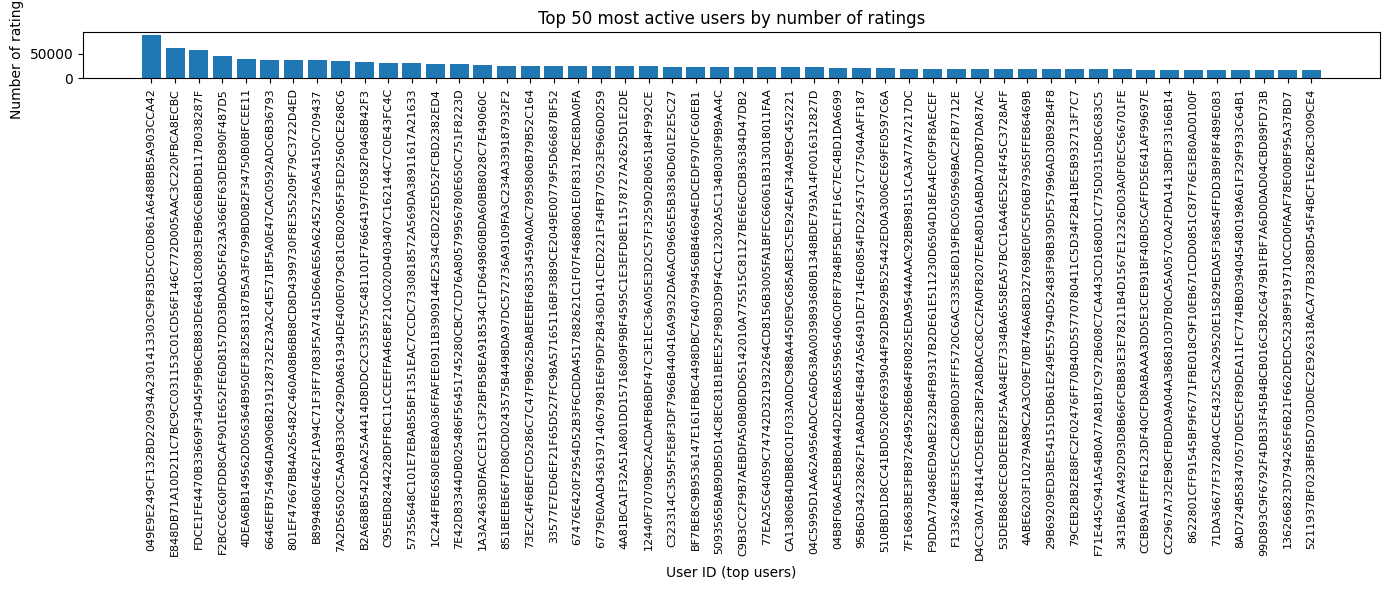

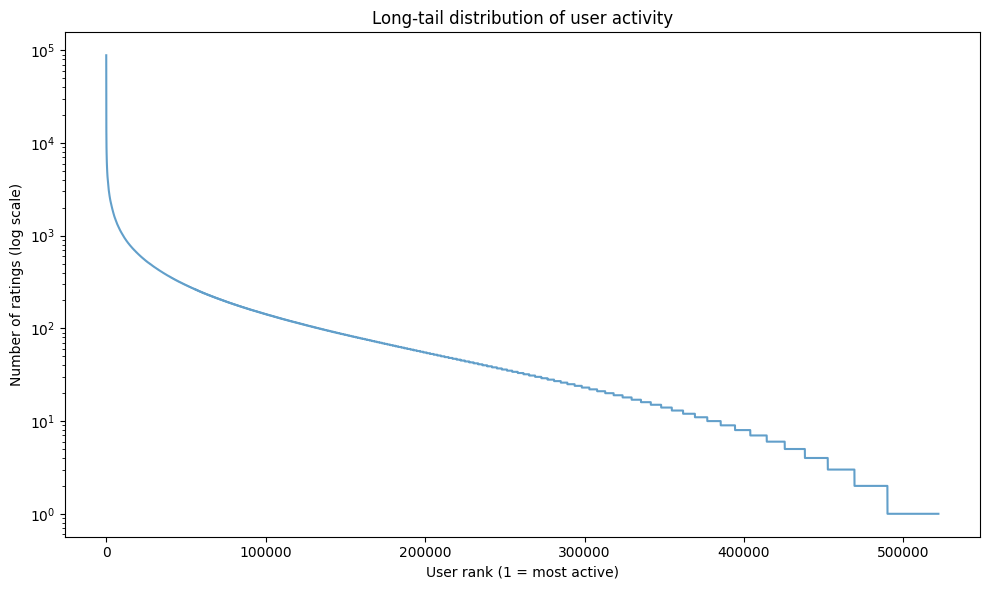

Total users: 521962
Most active user: {'user': '049E9E249CF132BD220934A2301413303C9F83D5CC0D861A6488BB5A903CCA42', 'n_ratings': 88403}
Median ratings per user: 33.0


In [26]:
# --- Distribution of user activity (ratings per user) ---
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/content/drive/MyDrive/communities"
RATING_FILES = [f"{DATA_DIR}/ratings-{i:05d}.tsv" for i in [0,1,6,7,9]]  # adjust list as needed

user_counts = {}

for rf in RATING_FILES:
    print("Reading:", rf)
    df = pd.read_csv(rf, sep="\t", usecols=["raterParticipantId"])
    counts = df["raterParticipantId"].value_counts()
    for pid, c in counts.items():
        user_counts[pid] = user_counts.get(pid, 0) + c

# Convert to DataFrame
activity_df = pd.DataFrame(list(user_counts.items()), columns=["user","n_ratings"])
activity_df = activity_df.sort_values("n_ratings", ascending=False).reset_index(drop=True)

# --- Plot 1: Top N bar chart ---
TOPN = 50
plt.figure(figsize=(14,6))
plt.bar(activity_df["user"].head(TOPN), activity_df["n_ratings"].head(TOPN))
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Number of ratings")
plt.xlabel("User ID (top users)")
plt.title(f"Top {TOPN} most active users by number of ratings")
plt.tight_layout()
plt.show()

# --- Plot 2: Long-tail distribution ---
plt.figure(figsize=(10,6))
plt.plot(range(1, len(activity_df)+1), activity_df["n_ratings"].values, alpha=0.7)
plt.yscale("log")
plt.xlabel("User rank (1 = most active)")
plt.ylabel("Number of ratings (log scale)")
plt.title("Long-tail distribution of user activity")
plt.tight_layout()
plt.show()

print("Total users:", len(activity_df))
print("Most active user:", activity_df.iloc[0].to_dict())
print("Median ratings per user:", activity_df['n_ratings'].median())


Found ratings files: 5


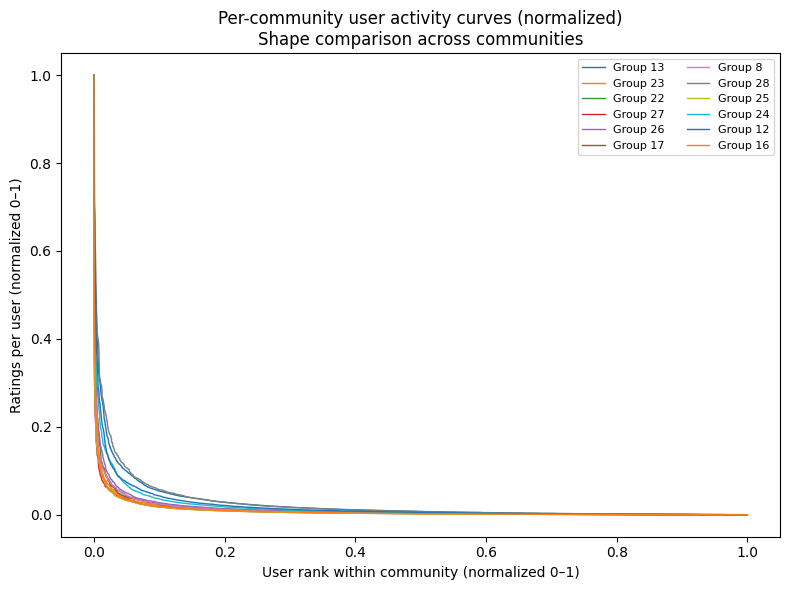

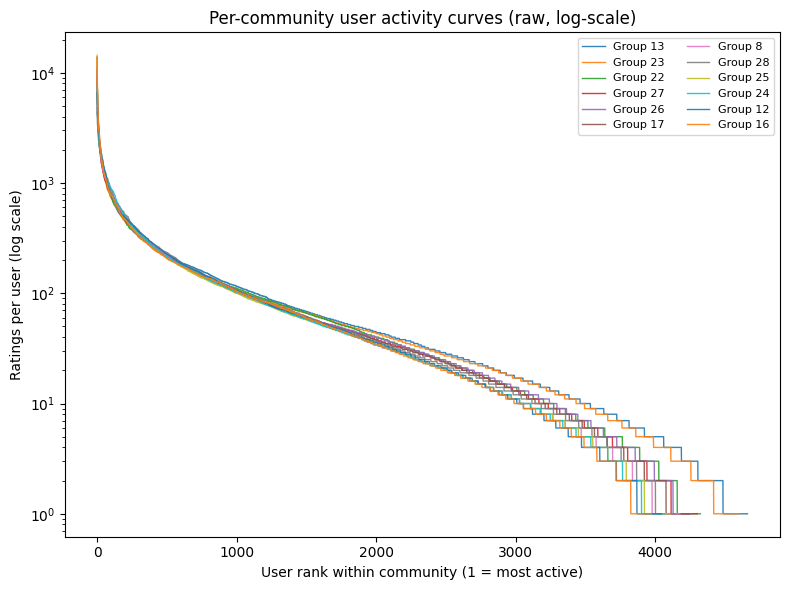

✅ Built curves for 12 communities (top by #users present in ratings).


In [6]:
# Overlay per-user long-tail activity curves by community
# - Reads ratings -> counts ratings per raterParticipantId
# - Maps raterParticipantId -> vertex (via user_id_map.parquet) -> community (via louvain_membership.parquet)
# - For each selected community, sorts users by activity and plots the curve (rank vs. ratings)
# - Produces two plots:
#     (A) Normalized curves (rank and counts rescaled 0..1) for shape comparison
#     (B) Raw counts with log-scale Y (optional but insightful)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# ------------ Paths & knobs ------------
BASE_DIR      = Path("/content/drive/MyDrive/communities")
RESULTS_DIR   = BASE_DIR / "results"
MEMBERSHIP_FP = RESULTS_DIR / "louvain_membership.parquet"   # must have vertex + community-like column
USERMAP_FP    = RESULTS_DIR / "user_id_map.parquet"          # columns: code, user_id (participantId)
# Ratings files live directly under /communities
RATINGS_GLOBS = str(BASE_DIR / "ratings-*.tsv")

# Discover them
rating_files = sorted(glob.glob(RATINGS_GLOBS))
if not rating_files:
    raise FileNotFoundError(f"No ratings-*.tsv files found under {BASE_DIR}")
print("Found ratings files:", len(rating_files))

# ------------ Load membership & detect columns ------------
memb = pd.read_parquet(MEMBERSHIP_FP)
# detect vertex col
v_col = None
for c in ["vertex","node","id","src"]:
    if c in memb.columns:
        v_col = c; break
if v_col is None:
    raise KeyError(f"Membership file has no vertex-like column. Found: {list(memb.columns)}")

# detect community col
comm_col = None
for c in ["community","merged_comm","partition","partition_key","label"]:
    if c in memb.columns:
        comm_col = c; break
if comm_col is None:
    raise KeyError(f"Membership file has no community/partition column. Found: {list(memb.columns)}")

memb = memb[[v_col, comm_col]].rename(columns={v_col:"vertex", comm_col:"community"})

# ------------ Load user_id_map (participantId <-> vertex code) ------------
idmap = pd.read_parquet(USERMAP_FP, columns=["code","user_id"]) \
            .rename(columns={"code":"vertex", "user_id":"raterParticipantId"})

# ------------ Count ratings per raterParticipantId (chunked) ------------
counts_dict = {}
usecol_detected = None

def detect_rater_col(path):
    # peek header to choose correct column
    hdr = pd.read_csv(path, sep="\t", nrows=0)
    for cand in ["raterParticipantId","participantId","user","user_id"]:
        if cand in hdr.columns:
            return cand
    raise ValueError(f"No rater id column in {path}. Columns: {hdr.columns.tolist()}")

for rf in rating_files:
    rcol = detect_rater_col(rf)
    usecol_detected = rcol  # last detected (should be consistent)
    for chunk in pd.read_csv(rf, sep="\t", usecols=[rcol], chunksize=1_000_000, dtype={rcol:str}):
        vc = chunk[rcol].value_counts()
        for uid, c in vc.items():
            counts_dict[uid] = counts_dict.get(uid, 0) + int(c)

activity = pd.DataFrame(list(counts_dict.items()), columns=["raterParticipantId","n_ratings"])

# ------------ Map raters -> vertex -> community ------------
act_with_code = activity.merge(idmap, on="raterParticipantId", how="left")  # adds vertex
act_with_comm = act_with_code.merge(memb, on="vertex", how="left")          # adds community
act_with_comm = act_with_comm.dropna(subset=["community"])
act_with_comm["community"] = act_with_comm["community"].astype(int)

# ------------ Pick communities to show ------------
sizes = act_with_comm.groupby("community")["raterParticipantId"].nunique().reset_index(name="n_users")
sizes = sizes.sort_values("n_users", ascending=False)
keep_comms = sizes.head(TOP_COMMUNITIES_BY_USERS)["community"].tolist()
subset = act_with_comm[act_with_comm["community"].isin(keep_comms)]

# ------------ Build per-community rank curves ------------
curves_norm = []   # normalized: rank_norm (0..1), count_norm (0..1)
curves_raw  = []   # raw: rank (1..k), count

for c in keep_comms:
    grp = subset[subset["community"] == c][["raterParticipantId","n_ratings"]]
    # ensure one row per user (in case of duplicates)
    grp = grp.groupby("raterParticipantId", as_index=False)["n_ratings"].sum()
    grp = grp.sort_values("n_ratings", ascending=False).reset_index(drop=True)
    k = len(grp)
    if k == 0:
        continue
    # raw curve
    curves_raw.append(pd.DataFrame({
        "community": c,
        "rank": np.arange(1, k+1, dtype=int),
        "count": grp["n_ratings"].to_numpy(dtype=np.int64)
    }))
    # normalized curve (shape-only)
    rank_norm = (np.arange(1, k+1) - 1) / max(1, k-1)
    max_cnt = max(1, grp["n_ratings"].max())
    count_norm = grp["n_ratings"] / max_cnt
    curves_norm.append(pd.DataFrame({
        "community": c,
        "rank_norm": rank_norm,
        "count_norm": count_norm.to_numpy(dtype=float)
    }))

curves_norm = pd.concat(curves_norm, ignore_index=True) if curves_norm else pd.DataFrame(columns=["community","rank_norm","count_norm"])
curves_raw  = pd.concat(curves_raw,  ignore_index=True) if curves_raw  else pd.DataFrame(columns=["community","rank","count"])

# ------------ Plot A: Normalized overlay (shape comparison) ------------
plt.figure(figsize=(8,6))
for c in keep_comms:
    dfc = curves_norm[curves_norm["community"] == c]
    if dfc.empty:
        continue
    plt.plot(dfc["rank_norm"], dfc["count_norm"], label=f"Group {c}", linewidth=1)
plt.xlabel("User rank within community (normalized 0–1)")
plt.ylabel("Ratings per user (normalized 0–1)")
plt.title("Per-community user activity curves (normalized)\nShape comparison across communities")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# ------------ Plot B: Raw long-tail overlay (log-scale Y) ------------
plt.figure(figsize=(8,6))
for c in keep_comms:
    dfc = curves_raw[curves_raw["community"] == c]
    if dfc.empty:
        continue
    plt.plot(dfc["rank"], dfc["count"], label=f"Group {c}", linewidth=1, alpha=0.9)
plt.yscale("log")
plt.xlabel("User rank within community (1 = most active)")
plt.ylabel("Ratings per user (log scale)")
plt.title("Per-community user activity curves (raw, log-scale)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

print(f"✅ Built curves for {len(keep_comms)} communities (top by #users present in ratings).")
